In [1]:
!pip install gym
!pip install shimmy

## Please choose here which ALG should be executed

In [2]:
if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

In [ ]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from finrl import config
from finrl.meta.preprocessor.preprocessors import  data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats,get_baseline
from stable_baselines3.common.logger import configure
import warnings
warnings.simplefilter("ignore", FutureWarning)
import datetime
import yfinance as yf

matplotlib.use("Agg")
import os
os.environ["NUMEXPR_MAX_THREADS"] = "128"

# 2.0 version - updated to gymnasium lib

In [3]:
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
        render_mode=None,
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_dim = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,), dtype=np.float32)
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.render_mode = render_mode
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        
        # Set the random seed
        self._np_random = None
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        
        info = {}
        
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()
            
            # Add trading performance to info
            info = {
                'portfolio_value': end_total_asset,
                'total_reward': tot_reward,
                'total_cost': self.cost,
                'total_trades': self.trades
            }
            if df_total_value["daily_return"].std() != 0:
                info['sharpe'] = sharpe

            return self.state, self.reward, self.terminal, False, info

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't buy fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            
            # Add current trading state info
            info = {
                'day': self.day,
                'current_asset_value': end_total_asset,
                'current_reward': self.reward / self.reward_scaling,
                'cost': self.cost,
                'trades': self.trades
            }

        return self.state, self.reward, self.terminal, False, info

    def reset(self, *, seed=None, options=None):
        # For reproducibility
        if seed is not None:
            self._seed(seed)
        
        # initiate state
        self.state = self._initiate_state()
        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1
        
        # Return observation and info dictionary as per Gymnasium API
        return self.state, {'initial_asset_value': self.asset_memory[0]}

    def render(self):
        if self.render_mode == "human":
            return self.state
        else:
            return None

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self._np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        # Handle both new and old stable-baselines3 API
        reset_result = e.reset()
        
        # Check if reset_result is a tuple (new API) or just the observation (old API)
        if isinstance(reset_result, tuple):
            obs, _ = reset_result  # Unpack if it's a tuple
        else:
            obs = reset_result  # Just use the value if it's not a tuple
            
        return e, obs

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

In [4]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield'] #TODO what needs to be in here?

tr_data = pd.read_csv("datasets/AAPL_tr.csv") # ,index_col="Date"
cols = list(tr_data.columns)
to_remove = ['Date','Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']

ratio_list = [col for col in cols if col not in to_remove]
print(len(ratio_list),ratio_list)



stock_dimension = 1
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tr_data

46 ['Dividends', 'Stock Splits', 'RSI_14', 'MA50', 'MA200', 'Golden_Cross', 'Death_Cross', 'Daily_Return', 'Volume_Ratio', 'Money_Flow', 'Cumulative_Money_Flow', 'EMA12', 'EMA26', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram', 'MACD_Crossover', 'BB_Middle', 'BB_StdDev', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Rolling_High_20d', 'Rolling_Low_20d', 'Near_Resistance', 'Near_Support', 'SPY_Close', 'SPY_Returns', 'Covariance', 'Market_Variance', 'Beta_30d', 'Volatility_20D', 'PE_Ratio', 'Forward_PE', 'PEG_Ratio', 'Price_to_Book', 'Dividend_Yield', 'Market_Cap', 'Enterprise_Value', 'Profit_Margin', 'Return_on_Equity', 'Revenue_Growth', 'Debt_to_Equity', 'Current_Ratio', 'EPS_Growth']
Stock Dimension: 1, State Space: 49


,Date,Ticker,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,...,Price_to_Book,Dividend_Yield,Market_Cap,Enterprise_Value,Profit_Margin,Return_on_Equity,Revenue_Growth,Debt_to_Equity,Current_Ratio,EPS_Growth
0,1993-01-29,AAPL,0.436564,0.443810,0.427507,0.431130,266100800,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
1,1993-02-01,AAPL,0.429318,0.443810,0.429318,0.443810,240553600,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
2,1993-02-02,AAPL,0.440188,0.445622,0.436564,0.436564,182336000,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
3,1993-02-03,AAPL,0.441999,0.441999,0.423884,0.434753,264185600,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
4,1993-02-04,AAPL,0.434752,0.436564,0.427507,0.431130,208152000,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,2018-09-19,AAPL,51.935553,52.201766,51.174941,51.904652,108495200,0.0,0.0,43.945406,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6458,2018-09-20,AAPL,52.349149,52.834038,52.090063,52.299232,106435200,0.0,0.0,43.365262,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6459,2018-09-21,AAPL,52.477497,52.615358,51.647953,51.735901,384986800,0.0,0.0,36.688971,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6460,2018-09-24,AAPL,51.536220,52.591566,51.491058,52.479851,110773600,0.0,0.0,40.501776,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1


In [5]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}
tr_data = tr_data.rename(columns={
    'Date': 'date',
    'Ticker': 'tic',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
tr_data




,date,tic,open,high,low,close,volume,Dividends,Stock Splits,RSI_14,...,Price_to_Book,Dividend_Yield,Market_Cap,Enterprise_Value,Profit_Margin,Return_on_Equity,Revenue_Growth,Debt_to_Equity,Current_Ratio,EPS_Growth
0,1993-01-29,AAPL,0.436564,0.443810,0.427507,0.431130,266100800,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
1,1993-02-01,AAPL,0.429318,0.443810,0.429318,0.443810,240553600,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
2,1993-02-02,AAPL,0.440188,0.445622,0.436564,0.436564,182336000,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
3,1993-02-03,AAPL,0.441999,0.441999,0.423884,0.434753,264185600,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
4,1993-02-04,AAPL,0.434752,0.436564,0.427507,0.431130,208152000,0.0,0.0,0.000000,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,2018-09-19,AAPL,51.935553,52.201766,51.174941,51.904652,108495200,0.0,0.0,43.945406,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6458,2018-09-20,AAPL,52.349149,52.834038,52.090063,52.299232,106435200,0.0,0.0,43.365262,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6459,2018-09-21,AAPL,52.477497,52.615358,51.647953,51.735901,384986800,0.0,0.0,36.688971,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
6460,2018-09-24,AAPL,51.536220,52.591566,51.491058,52.479851,110773600,0.0,0.0,40.501776,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1


In [6]:
#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = tr_data, **env_kwargs)

In [7]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [8]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)
RESULTS_DIR = "results"


## PPO

In [9]:
if if_using_ppo:

    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
        "device": "cpu"  # Explicitly use CPU for PPO
    }
    model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)
    
    
    # set up logger
    tmp_path = RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ppo.set_logger(new_logger_ppo)

## DDPG

In [10]:
if if_using_ddpg:

    agent = DRLAgent(env = env_train)
    model_ddpg = agent.get_model("ddpg")
    
    # set up logger
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

## A2C

In [11]:
if if_using_a2c:
    agent = DRLAgent(env = env_train)
    model_a2c = agent.get_model("a2c")


    # set up logger
    tmp_path = RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

## TD3

In [12]:
if if_using_td3:
    agent = DRLAgent(env = env_train)
    TD3_PARAMS = {"batch_size": 100, 
          "buffer_size": 1000000, 
          "learning_rate": 0.001}
    
    model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)
    
    
    # set up logger
    tmp_path = RESULTS_DIR + '/td3'
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

## SAC

In [13]:
if if_using_sac:
    agent = DRLAgent(env = env_train)
    SAC_PARAMS = {
        "batch_size": 128,
        "buffer_size": 1000000,
        "learning_rate": 0.0001,
        "learning_starts": 100,
        "ent_coef": "auto_0.1",
    }
    
    model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/sac'
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [14]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None


trained_ddpg = agent.train_model(model=model_ddpg, 
                                 tb_log_name='ddpg',
                                 total_timesteps=50000) if if_using_ddpg else None
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100) if if_using_sac else None # was 30k

## TRADING

In [15]:
processed_full_AAPL = pd.read_csv("data/AAPL_technical_analysis.csv")
print(processed_full_AAPL)

#0.8/0.2 split
TRAIN_START_DATE = "1993-01-29"
TRAIN_END_DATE = "2018-09-25"
TEST_START_DATE = "2018-09-26"
TEST_END_DATE = "2025-02-28"

processed_full_AAPL = processed_full_AAPL.rename(columns={
    'Date': 'date',
    'Ticker': 'tic',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})


trade_data = data_split(processed_full_AAPL, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

            Date Ticker        Open        High         Low       Close  \
0     1993-01-29   AAPL    0.436564    0.443810    0.427507    0.431130   
1     1993-02-01   AAPL    0.429318    0.443810    0.429318    0.443810   
2     1993-02-02   AAPL    0.440188    0.445622    0.436564    0.436564   
3     1993-02-03   AAPL    0.441999    0.441999    0.423884    0.434753   
4     1993-02-04   AAPL    0.434752    0.436564    0.427507    0.431130   
...          ...    ...         ...         ...         ...         ...   
8072  2025-02-24   AAPL  244.929993  248.860001  244.419998  247.100006   
8073  2025-02-25   AAPL  248.000000  250.000000  244.910004  247.039993   
8074  2025-02-26   AAPL  244.330002  244.979996  239.130005  240.360001   
8075  2025-02-27   AAPL  239.410004  242.460007  237.059998  237.300003   
8076  2025-02-28   AAPL  236.949997  242.089996  230.199997  241.839996   

         Volume  Dividends  Stock Splits     RSI_14  ...  Price_to_Book  \
0     266100800        0

In [16]:
trade_data.head()

,date,tic,open,high,low,close,volume,Dividends,Stock Splits,RSI_14,...,Price_to_Book,Dividend_Yield,Market_Cap,Enterprise_Value,Profit_Margin,Return_on_Equity,Revenue_Growth,Debt_to_Equity,Current_Ratio,EPS_Growth
0,2018-09-26,AAPL,52.529772,53.183423,52.235033,52.391911,95938800,0.0,0.0,46.451187,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
1,2018-09-27,AAPL,53.200077,53.822827,53.133520,53.468666,120724800,0.0,0.0,54.507256,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
2,2018-09-28,AAPL,53.430620,53.680196,53.247600,53.656429,91717600,0.0,0.0,59.671061,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
3,2018-10-01,AAPL,54.181734,54.531141,53.801431,54.017727,94403200,0.0,0.0,54.969354,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1
4,2018-10-02,AAPL,54.015358,54.669009,53.867991,54.497871,99152800,0.0,0.0,62.235378,...,49.27814,44.0,3285279309824,3460245225472,24.295,136.52,4.0,145.0,0.923,10.1


In [17]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else [None, None]

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else [None, None]

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else [None, None]

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else [None, None]

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else [None, None]

hit end!


In [18]:
# df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_a2c.shape
# df_account_value_td3.shape
# df_account_value_sac.shape

In [19]:
# df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_a2c.tail()
# df_account_value_td3.tail()
# df_account_value_sac.tail()

In [20]:
# df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_a2c.head()
# df_actions_td3.head()
# df_actions_sac.head()

# Backtest Our Strategy

In [21]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

if if_using_td3:
  print("\n atd3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results===========

 sac:
Annual return          0.294864
Cumulative returns     4.233210
Annual volatility      0.293511
Sharpe ratio           1.027954
Calmar ratio           0.938260
Stability              0.868123
Max drawdown          -0.314266
Omega ratio            1.206782
Sortino ratio          1.523628
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.992644
Daily value at risk   -0.035782
dtype: float64


In [22]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1614, 8)
Annual return          0.080174
Cumulative returns     0.638774
Annual volatility      0.196526
Sharpe ratio           0.491490
Calmar ratio           0.216183
Stability              0.807613
Max drawdown          -0.370862
Omega ratio            1.103386
Sortino ratio          0.683598
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.926156
Daily value at risk   -0.024377
dtype: float64


In [23]:
df_account_value_sac

,date,account_value
0,2018-09-26,1.000000e+06
1,2018-09-27,1.000102e+06
2,2018-09-28,1.000135e+06
3,2018-10-01,1.000238e+06
4,2018-10-02,1.000424e+06
...,...,...
1609,2025-02-21,5.415148e+06
1610,2025-02-24,5.449330e+06
1611,2025-02-25,5.448006e+06
1612,2025-02-26,5.300693e+06


In [24]:
# Fixed version of the backtest visualization function



def plot_strategy_with_indices(account_df, start_date=None, end_date=None):
    """
    Plot trading strategy performance against major indices
    
    Parameters:
    -----------
    account_df : DataFrame 
        DataFrame with 'date' and 'account_value' columns or datetime index
    start_date, end_date : str
        Optional date range for the plot in 'YYYY-MM-DD' format
    """
    # Make a copy and handle date formatting
    df = account_df.copy()
    
    # Convert index to column if needed
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index()
        if 'index' in df.columns and 'date' not in df.columns:
            df = df.rename(columns={'index': 'date'})
    
    # Ensure date column is datetime
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    else:
        raise ValueError("DataFrame must have a 'date' column or datetime index")
    
    # Set date range
    if start_date is None:
        start_date = df['date'].min().strftime('%Y-%m-%d')
    if end_date is None:
        end_date = df['date'].max().strftime('%Y-%m-%d')
    
    # Index tickers and their display names
    indices = {
        '^GSPC': 'S&P 500',
        '^DJI': 'Dow Jones',
        '^NDX': 'NASDAQ 100'
    }
    
    # Download index data
    index_data = {}
    for ticker, name in indices.items():
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if len(data) > 0:
                index_data[ticker] = data
            else:
                print(f"No data found for {name}")
        except Exception as e:
            print(f"Error downloading {name} data: {e}")
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Performance plot
    first_value = float(df['account_value'].iloc[0])
    
    # Plot strategy value
    ax1.plot(df['date'], df['account_value'], 
             label='Trading Strategy', 
             color='blue', 
             linewidth=2)
    
    # Style definitions for indices
    styles = {
        '^GSPC': {'color': 'green', 'linestyle': '--', 'linewidth': 1.5},
        '^DJI': {'color': 'red', 'linestyle': '-.', 'linewidth': 1.5},
        '^NDX': {'color': 'purple', 'linestyle': ':', 'linewidth': 1.5}
    }
    
    # Calculate returns for all indices
    index_returns = {}
    
    # Plot indices
    for ticker, data in index_data.items():
        # Normalize to same starting point - Fix the float() warnings
        first_index = float(data['Close'].iloc[0])  # Convert to float correctly
        scaled_values = data['Close'] * (first_value / first_index)
        
        # Add to plot
        style = styles.get(ticker, {'color': 'gray', 'linestyle': '--', 'linewidth': 1})
        ax1.plot(data.index, scaled_values, 
                 label=indices[ticker], 
                 **style)
        
        # Calculate returns - Fix the float() warnings
        first_price = float(data['Close'].iloc[0])
        last_price = float(data['Close'].iloc[-1])
        total_return = ((last_price / first_price) - 1) * 100
        index_returns[indices[ticker]] = total_return
    
    # Strategy metrics
    strategy_return = float((df['account_value'].iloc[-1] / df['account_value'].iloc[0] - 1) * 100)
    
    # Calculate drawdown
    df['peak'] = df['account_value'].cummax()
    df['drawdown'] = (df['account_value'] / df['peak'] - 1) * 100
    max_drawdown = float(df['drawdown'].min())
    
    # Daily returns for Sharpe ratio
    df['daily_return'] = df['account_value'].pct_change()
    trading_days = 252
    sharpe = float(np.sqrt(trading_days) * (df['daily_return'].mean() / df['daily_return'].std()))
    
    # Format the plot
    ax1.set_title('Trading Strategy vs Major Indices', fontsize=16)
    ax1.set_ylabel('Account Value ($)', fontsize=12)
    ax1.legend(fontsize=10, loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Use comma separator for y-axis
    ax1.get_yaxis().set_major_formatter(
        plt.matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )
    
    # Add metrics text box
    metrics = (
        f"Trading Strategy:\n"
        f"  Total Return: {strategy_return:.2f}%\n"
        f"  Sharpe Ratio: {sharpe:.2f}\n"
        f"  Max Drawdown: {max_drawdown:.2f}%\n\n"
    )
    
    metrics += "Index Performance:\n"
    for name, ret in index_returns.items():
        # FIX: ret is now a Python float, not a Series
        metrics += f"  {name}: {ret:.2f}%\n"
    
    # Place text box in the plot
    ax1.text(0.02, 0.02, metrics, 
             transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'),
             fontsize=9,
             verticalalignment='bottom')
    
    # Drawdown plot
    ax2.fill_between(df['date'], df['drawdown'], 0, color='red', alpha=0.3)
    ax2.set_title('Drawdown (%)', fontsize=14)
    ax2.set_ylabel('Drawdown %', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit with some padding
    ax2.set_ylim(min(max_drawdown * 1.2, -40), 5)
    
    plt.tight_layout()
    return fig, df

# Example usage:
# fig, stats = plot_strategy_with_indices(df_account_value_sac)
# plt.show()

==============Compare to DJIA===========
YF.download() has changed argument auto_adjust default to True


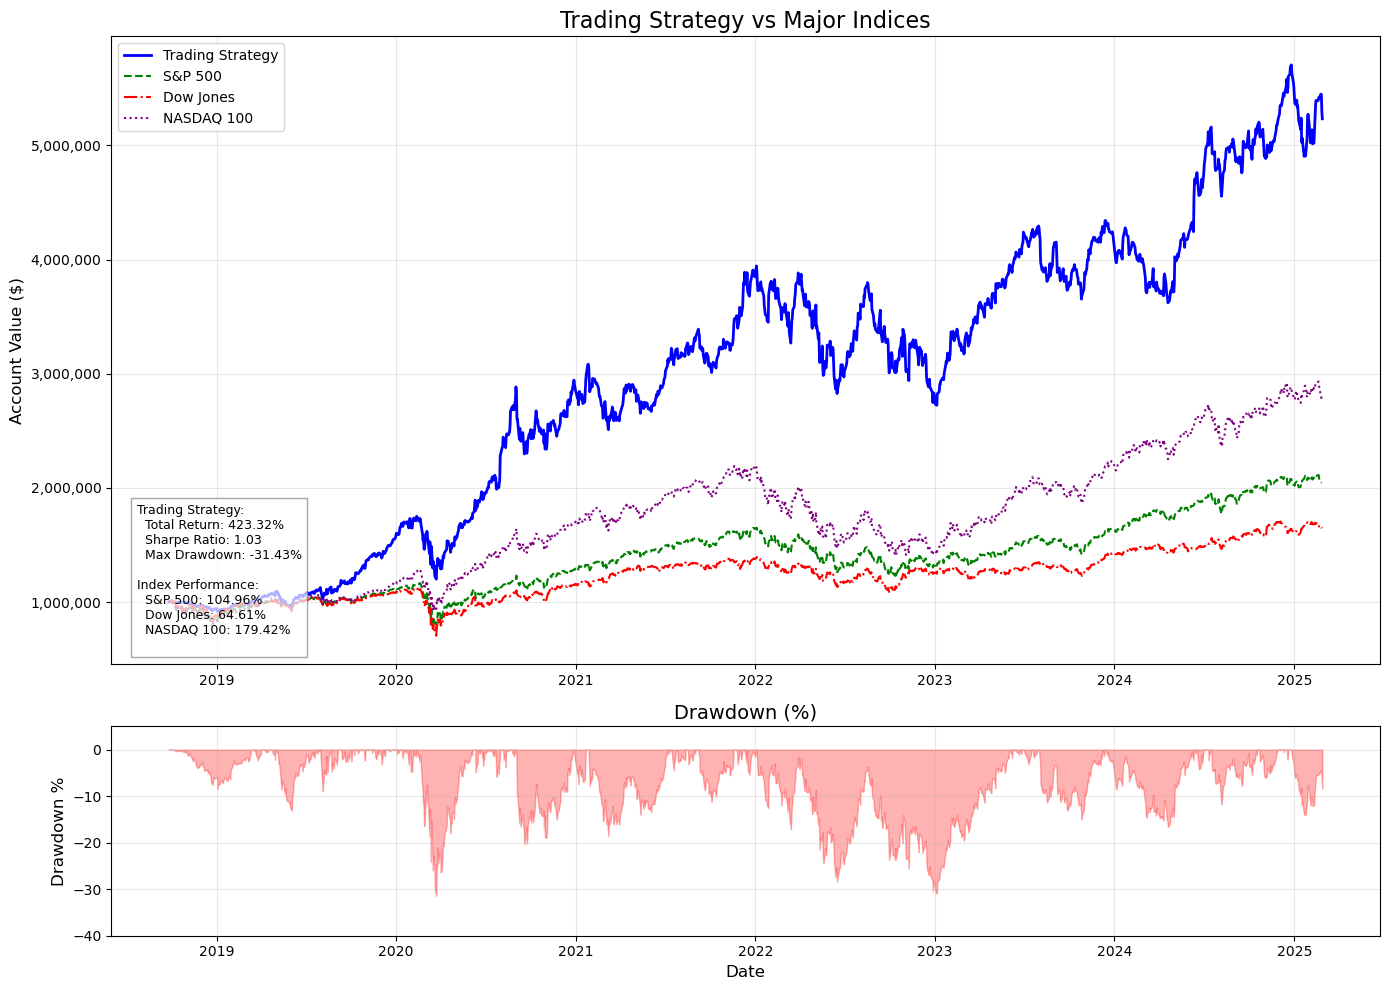

Strategy Summary:
Initial investment: $1,000,000.00
Final value: $5,233,210.49
Total return: 423.32%


In [25]:
print("==============Compare to DJIA===========")


%matplotlib inline

# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX

if if_using_ppo:
    fig, stats = plot_strategy_with_indices(df_account_value_ppo)
    plt.show()
if if_using_ddpg:
    fig, stats = plot_strategy_with_indices(df_account_value_ddpg)
    plt.show()
if if_using_a2c:
    fig, stats = plot_strategy_with_indices(df_account_value_a2c)
    plt.show()
if if_using_td3:
    fig, stats = plot_strategy_with_indices(df_account_value_td3)
    plt.show()
if if_using_sac:
    fig, stats = plot_strategy_with_indices(df_account_value_sac)
    plt.show()
    
# Print simple summary statistics (using proper float conversion)
start_val = float(stats['account_value'].iloc[0])
end_val = float(stats['account_value'].iloc[-1])
total_return = (end_val / start_val - 1) * 100

print(f"Strategy Summary:")
print(f"Initial investment: ${start_val:,.2f}")
print(f"Final value: ${end_val:,.2f}")
print(f"Total return: {total_return:.2f}%")

# TODO
- rename indexes in download_data